# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf
from IPython.display import display
import re
import talos

# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

# hospitalisations features given as input
list_hosp_features = [
    #'NEW_HOSP',
    'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
]

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

Additional information: what is the target, should some features remain unscaled?

In [3]:
# target, should be one of the hosp features
target = 'TOT_HOSP'

# features that should not be scaled
unscaled = [
    #'NEW_HOSP',
    #'TOT_HOSP',
    #'TOT_HOSP_log',
    #'TOT_HOSP_pct',
    #'Fièvre',
    #'Mal de gorge',
    #'Dyspnée',
    #'Agueusie',
    #'Anosmie',
    #'Coronavirus',
    #'Virus',
    #'Température corporelle humaine',
    #'Épidémie',
    #'Symptôme',
    #'Thermomètre',
    #'Grippe espagnole',
    #'Paracétamol',
    #'Respiration',
    #'Toux',
]

In [4]:
date_begin = "2020-02-01"

def log_values(df, columns: list = None, base: int = 10, inf_value='drop'):
    """
    add log values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :param inf_value: value to give for the inf created by the log. Can be integer or 'drop' (dropping the values)
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
        
    if inf_value == 'drop':
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
    else: #inf_value should be an integer
        df = df.replace([np.inf, -np.inf], inf_value)
    return df
        

def pct_values(df, columns: list = None, add_one: bool = False):
    """
    add percentage values to the dataframe
    :param df: dataframe to change
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param add_one: if True, the percentage of difference add a value of 100% to each percentage
    :return dataframe with pct change values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    new_columns = [f"{name}_pct" for name in columns]
    df[new_columns] = df[columns].pct_change()
    if add_one:
        df[new_columns] = df[new_columns] + 1
    return df
    

def create_dataframe_hospi(hospi_france_tot, hospi_france_new, hospi_belgium, department_france, geo, 
                           new_hosp_in=True, tot_hosp=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    :param hospi_france_tot: url/path for the total french hospitalisations csv
    :param hospi_france_new: url/path for the new french hospitalisations csv
    :param hospi_belgium: url/path for the belgian hospitalisations csv
    :param department_france: url/path for the mapping of french department to regions
    :param geo: geocode of the region that should be incuded in the final dict
    :param new_hosp_in: if True, includes the new daily hospitalisations (inwards)
    :param tot_hosp: if True, includes the total hospitalisations
    :return dict of {geocode: hosp_df} where hosp is hospitalisation dataframe of each geocode
    """
    columns_be = {}  # only for belgium, not for france (the files are handled differently)
    data_columns = []  # final data columns that will be present in the df
    if new_hosp_in:
        columns_be['NEW_IN'] = 'sum'
        data_columns.append("NEW_HOSP")
    if tot_hosp:
        columns_be['TOTAL_IN'] = 'sum'
        data_columns.append("TOT_HOSP")
    if len(columns_be) == 0:
        raise Exception("no hospitalisation column specified")
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    
    # French data: total hospitalisation
    if tot_hosp:
        hospitalisations = pd.read_csv(hospi_france_tot, sep=";", parse_dates=['jour'], date_parser=date_parser)
        hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
        data_fr_tot = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"], as_index=False).agg({"hosp": "sum"})
    
    # French data: new hospitalisation
    if new_hosp_in:
        hospitalisations = pd.read_csv(hospi_france_new, sep=";", parse_dates=['jour'], date_parser=date_parser)
        data_fr_new = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(
            ["regionTrends", "jour"],as_index=False).agg({"incid_hosp": "sum"})
    
    # merge the french data
    common_columns = ["regionTrends", "jour"]
    if tot_hosp and new_hosp_in:
        data_fr = data_fr_tot.merge(data_fr_new, how='outer',left_on=common_columns, right_on=common_columns).fillna(0)
    elif tot_hosp:
        data_fr = data_fr_tot
    elif new_hosp_in:
        data_fr = data_fr_new
    data_fr = data_fr.rename(columns={"jour": "DATE", "regionTrends": "LOC", "hosp": "TOT_HOSP", "incid_hosp": "NEW_HOSP"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium, parse_dates=['DATE'], date_parser=date_parser).groupby(
        ["DATE"], as_index=False).agg(columns_be).rename(
        columns={"TOTAL_IN": "TOT_HOSP", "NEW_IN": "NEW_HOSP"})
    data_be["LOC"] = "BE"
    
    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    add_entry = [0 for i in range(len(data_columns))]  # each missing entry consist of zero for each data col
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, *add_entry])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", *data_columns]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[(full_data.index.get_level_values('LOC') == k) & 
                                     (full_data.index.get_level_values('DATE') <= highest_date)]
    return data_dic


def create_df_trends(url_trends, geo):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    if len(renaming)==0:
        return {k: pd.DataFrame() for k in geocodes}
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france_new = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi.csv"
url_hospi_france_tot = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"

# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes)
df_hospi = create_dataframe_hospi(url_hospi_france_tot, url_hospi_france_new, url_hospi_belgium, 
                                  url_department_france, geocodes)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    df_hospi[k] = log_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = pct_values(df_hospi[k], columns=['TOT_HOSP'])
    df_hospi[k] = df_hospi[k][list_hosp_features]
    
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """

# Preprocess data

## Normalization [0,1]

In [6]:
df_trends['BE']

Fièvre  Mal de gorge   Symptôme
LOC DATE                                          
BE  2020-02-04  22.887312     23.406132  19.467604
    2020-02-05  22.746086     23.450726  19.385453
    2020-02-06  22.179296     22.692960  19.071650
    2020-02-07  21.876634     22.179757  18.728931
    2020-02-08  21.865878     22.339013  18.370240
...                   ...           ...        ...
    2021-01-17  17.382688     26.323271  20.589605
    2021-01-18  17.613334     27.298279  21.141608
    2021-01-19  17.801144     28.288480  21.614280
    2021-01-20  18.128606     29.492143  21.946744
    2021-01-21  18.426436     29.379409  21.998369

[353 rows x 3 columns]

In [7]:
inverse_param = {}
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    if len(list_topics) !=0:
        to_scale = [name for name in df_trends[k].columns if name not in unscaled]
        df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=to_scale, index=df_trends[k].index)
    # store a tuple of min,max
    inverse_param[k] = (df_hospi[k][target].min(), df_hospi[k][target].max())
    to_scale = [name for name in df_hospi[k].columns if name not in unscaled]
    df_hospi[k][to_scale] = pd.DataFrame(scaler.fit_transform(df_hospi[k][to_scale].values), columns=to_scale, index=df_hospi[k].index)
# store the inverse transform for the target only
inverse_transform = lambda df,k: df[[target]] * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0] 
inverse_transform_fun = lambda val,k: val * (inverse_param[k][1] - inverse_param[k][0]) + inverse_param[k][0]
df_hospi['BE']

TOT_HOSP
LOC DATE                
BE  2020-03-12  0.000000
    2020-03-13  0.007370
    2020-03-14  0.017270
    2020-03-15  0.030217
    2020-03-16  0.047029
...                  ...
    2021-01-16  0.260921
    2021-01-17  0.260941
    2021-01-18  0.261598
    2021-01-19  0.262534
    2021-01-20  0.263928

[315 rows x 1 columns]

In [8]:
inverse_transform(df_hospi['BE'], 'BE')

TOT_HOSP
LOC DATE                   
BE  2020-03-12    38.000000
    2020-03-13    90.857143
    2020-03-14   161.857143
    2020-03-15   254.714286
    2020-03-16   375.285714
...                     ...
    2021-01-16  1909.285714
    2021-01-17  1909.428571
    2021-01-18  1914.142857
    2021-01-19  1920.857143
    2021-01-20  1930.857143

[315 rows x 1 columns]

Map to the sum of hospitalizations

In [9]:
def mapper(data, loc):
    allowed_map = ['TOT_HOSP']  # implemented mapping
    if target == 'TOT_HOSP':
        return [inverse_transform_fun(val,loc) for val in data]
    else:
        raise Exception(f"cannot map {target} to TOT_HOSP")
    
    



## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [10]:
n_forecast = 15  # Number of days we want to predict
n_samples = 25  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date

## Add lag

In [11]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [12]:
def timeseries_add_lag(data, lag, dropna=True):
    #Adds lagged values to dataframe
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


if len(list_topics) !=0:
    merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
else:
    merged_df = {k: df_hospi[k] for k in geocodes}
    
# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
print(n_features)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

4


In [13]:
merged_df['BE']

TOT_HOSP    Fièvre  Mal de gorge  Symptôme
LOC DATE                                                  
BE  2020-03-16  0.030217  0.992217      0.985293  0.993825
    2020-03-17  0.047029  1.000000      1.000000  0.952982
    2020-03-18  0.068960  0.969401      0.968984  0.875662
    2020-03-19  0.096528  0.902796      0.899740  0.788355
    2020-03-20  0.124016  0.825921      0.827677  0.705806
...                  ...       ...           ...       ...
    2021-01-16  0.260921  0.031415      0.086851  0.070700
    2021-01-17  0.260921  0.039447      0.111463  0.070816
    2021-01-18  0.260941  0.058793      0.146207  0.075368
    2021-01-19  0.261598  0.061902      0.159582  0.082803
    2021-01-20  0.262534  0.064433      0.173166  0.089170

[311 rows x 4 columns]

In [14]:
lagged_df['BE']

TOT_HOSP(t-24)  Fièvre(t-24)  Mal de gorge(t-24)  \
LOC DATE                                                           
BE  2020-04-09        0.030217      0.992217            0.985293   
    2020-04-10        0.047029      1.000000            1.000000   
    2020-04-11        0.068960      0.969401            0.968984   
    2020-04-12        0.096528      0.902796            0.899740   
    2020-04-13        0.124016      0.825921            0.827677   
...                        ...           ...                 ...   
    2021-01-16        0.341852      0.032428            0.174691   
    2021-01-17        0.337131      0.027131            0.179176   
    2021-01-18        0.333566      0.024102            0.179236   
    2021-01-19        0.330179      0.024234            0.176290   
    2021-01-20        0.327391      0.021182            0.171056   

                Symptôme(t-24)  TOT_HOSP(t-23)  Fièvre(t-23)  \
LOC DATE                                                       
BE  2020-04-09        0.993825        0.047029      1.000000   
    2020-04-10        0.952982        0.068960      0.969401   
    2020-04-11        0.875662        0.096528      0.902796   
    2020-04-12        0.788355        0.124016      0.825921   
    2020-04-13        0.705806        0.154154      0.737337   
...                        ...             ...           ...   
    2021-01-16        0.055506        0.337131      0.027131   
    2021-01-17        0.056430        0.333566      0.024102   
    2021-01-18        0.055455        0.330179      0.024234   
    2021-01-19        0.055896        0.327391      0.021182   
    2021-01-20        0.056166        0.324642      0.022013   

                Mal de gorge(t-23)  Symptôme(t-23)  TOT_HOSP(t-22)  \
LOC DATE                                                             
BE  2020-04-09            1.000000        0.952982        0.068960   
    2020-04-10            0.968984        0.875662        0.096528   
    2020-04-11            0.899740        0.788355        0.124016   
    2020-04-12            0.827677        0.705806        0.154154   
    2020-04-13            0.746625        0.623811        0.186881   
...                            ...             ...             ...   
    2021-01-16            0.179176        0.056430        0.333566   
    2021-01-17            0.179236        0.055455        0.330179   
    2021-01-18            0.176290        0.055896        0.327391   
    2021-01-19            0.171056        0.056166        0.324642   
    2021-01-20            0.163624        0.054560        0.319463   

                Fièvre(t-22)  ...  Mal de gorge(t-2)  Symptôme(t-2)  \
LOC DATE                      ...                                     
BE  2020-04-09      0.969401  ...           0.195295       0.156808   
    2020-04-10      0.902796  ...           0.179692       0.146418   
    2020-04-11      0.825921  ...           0.178734       0.137547   
    2020-04-12      0.737337  ...           0.169334       0.127936   
    2020-04-13      0.653217  ...           0.175427       0.122394   
...                      ...  ...                ...            ...   
    2021-01-16      0.024102  ...           0.058870       0.050422   
    2021-01-17      0.024234  ...           0.069530       0.060728   
    2021-01-18      0.021182  ...           0.086851       0.070700   
    2021-01-19      0.022013  ...           0.111463       0.070816   
    2021-01-20      0.021403  ...           0.146207       0.075368   

                TOT_HOSP(t-1)  Fièvre(t-1)  Mal de gorge(t-1)  Symptôme(t-1)  \
LOC DATE                                                                       
BE  2020-04-09       0.782304     0.191851           0.179692       0.146418   
    2020-04-10       0.780431     0.177371           0.178734       0.137547   
    2020-04-11       0.776866     0.161917           0.169334       0.127936   
    2020-04-12       0.772783     0.150518           0.175427  

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [15]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(287, 25, 4)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [16]:
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

0

In [17]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [18]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 4, 13), datetime.date(2020, 4, 14), datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), datetime.date(2020, 4, 20), datetime.date(2020, 4, 21), datetime.date(2020, 4, 22), datetime.date(2020, 4, 23), datetime.date(2020, 4, 24), datetime.date(2020, 4, 25), datetime.date(2020, 4, 26), datetime.date(2020, 4, 27)], [datetime.date(2020, 4, 14), datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), datetime.date(2020, 4, 20), datetime.date(2020, 4, 21), datetime.date(2020, 4, 22), datetime.date(2020, 4, 23), datetime.date(2020, 4, 24), datetime.date(2020, 4, 25), datetime.date(2020, 4, 26), datetime.date(2020, 4, 27), datetime.date(2020, 4, 28)], [datetime.date(2020, 4, 15), datetime.date(2020, 4, 16), datetime.date(2020, 4, 17), datetime.date(2020, 4, 18), datetime.date(2020, 4, 19), date

## Split into train - test set

In [19]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(269, 25, 4)
(269, 15, 1)


In [20]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 15)


## Real-time prediction

In [21]:
fit_first_days = 280  # use 'fit_first_days' days for the first fit
fit_steps_days = 30  # every 'fit_steps_days' days, do a new fit of the data
epochs = 2800 # epochs used to train the model

In [22]:
def get_x_dates(idx):
    return np.array(x_dates)[idx]
    
def get_y_dates(idx, horizon=1):
    """
    return the target dates on the corresponding indexes
    :param horizon: int corresponding to the horizon of dates. Can be
        - a value in [1, n_forecast] corresponding to the given horizon date (1: tomorrow, 2: in two days, ...)
        - None gives all target dates in [1, n_forecast]
    """
    result_dates = np.array(y_dates)[idx]
    if horizon is not None:
        result_dates = result_dates[:,horizon-1]
    return result_dates

def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [23]:
def plot_prediction_vs_actual(predicted, idx, loc, horizon=1, show_fit=50, mode=0, map_to_hosp=True):
    """
    
    :param loc: location of the prediction
    :param predicted: value predicted
    :param idx: index of the y_values used
    :param horizon: horizon that must be plot
    :param show_fit: max number of days of fit that must be plot
    :param mode: used when horizon > 1. tell how to plot with respect to the horizons
        - mode = 0: plot one graph for all values for this specific horizon
        - mode = 1: plot one graph for all horizon in [1, horizon]
    :param map_to_hosp: if True, show the plot of predictions mapped to the total number of hosp
    """
    target_expected = data_value_region(idx, loc)[1]
    
    if mode == 0:
        horizon_range = range(horizon, horizon+1)
    elif mode == 1:
        horizon_range = range(1, horizon+1)
        
    for horizon in horizon_range:
        fig = plt.figure(figsize=(6,3))
        if show_fit > 0:
            fit_idx = [idx[0]-i for i in range(show_fit, 0, -1) if idx[0]-i >= 0]
            fit_dates = get_y_dates(fit_idx, horizon=horizon)
            # get all predictions of corresponding horizon that were used to fit the model
            fit_values = data_value_region(fit_idx, loc)[1][:,horizon-1].reshape(-1)
            if map_to_hosp:
                fit_values = mapper(fit_values, loc)
            plt.plot(fit_dates, fit_values, label="fitting used")

        prediction_dates = get_y_dates(idx, horizon=horizon)
        if map_to_hosp:
            target_expected_map = mapper(target_expected[:,horizon-1].reshape(-1), loc)
        else:
            target_expected_map = target_expected[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, target_expected_map, marker=".", label="True value")

        if map_to_hosp:
            prediction = mapper(predicted[:,horizon-1].reshape(-1), loc)
        else:
            prediction = predicted[:,horizon-1].reshape(-1)
        plt.plot(prediction_dates, prediction, marker='.', label=f"prediction horizon {horizon}")

        ax = fig.axes[0]
        # set locator
        if len(idx) + show_fit > 50:  # monthly locator
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        else:  # weekly locator
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.grid()
        if mode != 0:
            plt.show()
    

In [25]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_idx = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(geocodes), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_idx.append(predict_idx)
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

In [26]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target_expected = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        plot_prediction_vs_actual(prediction, prediction_idx[i], loc)
        plt.title(loc)

# Comparison between several models

In [24]:
prop_train = 0.6 # 60% of data for training
prop_valid = 0.2 # 20% of data for validation
prop_test = 0.2 # 20% of data for testing

date_f = "%Y-%m-%d"
lagged_df_no_index = lagged_df['BE'].reset_index()
first_date = datetime.strptime(lagged_df_no_index['DATE'].min().strftime(date_f), date_f).date()
last_date = datetime.strptime(lagged_df_no_index['DATE'].max().strftime(date_f), date_f).date()
total_days = (last_date - first_date).days

end_train = first_date + timedelta(days=total_days*prop_train)
end_valid = end_train + timedelta(days=total_days*prop_valid)
end_test = end_valid + timedelta(days=total_days*prop_test)

end_train = end_train.strftime(date_f)
end_valid = end_valid.strftime(date_f)
end_test = end_test.strftime(date_f)

print(f"Training period : {first_date.strftime(date_f)} -> {end_train}")
print(f"Validation period : {end_train} -> {end_valid}")
print(f"Testing period : {end_valid} -> {end_test}")

Training period : 2020-04-09 -> 2020-09-27
Validation period : 2020-09-27 -> 2020-11-23
Testing period : 2020-11-23 -> 2021-01-19


In [25]:
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(test_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [26]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 15)


In [27]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
5/5 [==============================] - 1s 164ms/step - loss: 0.0846 - val_loss: 0.3039
Epoch 2/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0689 - val_loss: 0.2641
Epoch 3/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0529 - val_loss: 0.2154
Epoch 4/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0356 - val_loss: 0.1563
Epoch 5/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0222 - val_loss: 0.1081
Epoch 6/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0159 - val_loss: 0.0999
Epoch 7/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0122 - val_loss: 0.1020
Epoch 8/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0994
Epoch 9/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 0.1057
Epoch 10/2800
5/5 [==============================] - 0s 26ms/step - loss: 0.0057 - val_loss: 0.1046
Epoch 11

5/5 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0520
Epoch 84/2800
5/5 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0518
Epoch 85/2800
5/5 [==============================] - 0s 51ms/step - loss: 0.0011 - val_loss: 0.0516
Epoch 86/2800
5/5 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0514
Epoch 87/2800
5/5 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0512
Epoch 88/2800
5/5 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0510
Epoch 89/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0508
Epoch 90/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0507
Epoch 91/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0505
Epoch 92/2800
5/5 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0503
Epoch 93/2800


Epoch 162/2800
5/5 [==============================] - 0s 28ms/step - loss: 6.9241e-04 - val_loss: 0.0377
Epoch 163/2800
5/5 [==============================] - 0s 28ms/step - loss: 6.8933e-04 - val_loss: 0.0375
Epoch 164/2800
5/5 [==============================] - 0s 27ms/step - loss: 6.8412e-04 - val_loss: 0.0373
Epoch 165/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.8159e-04 - val_loss: 0.0371
Epoch 166/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.7595e-04 - val_loss: 0.0370
Epoch 167/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.7417e-04 - val_loss: 0.0368
Epoch 168/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.6790e-04 - val_loss: 0.0366
Epoch 169/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.6709e-04 - val_loss: 0.0365
Epoch 170/2800
5/5 [==============================] - 0s 25ms/step - loss: 6.5996e-04 - val_loss: 0.0363
Epoch 171/2800
5/5 [==============================] - 0

5/5 [==============================] - 0s 25ms/step - loss: 5.2717e-04 - val_loss: 0.0288
Epoch 241/2800
5/5 [==============================] - 0s 26ms/step - loss: 5.2620e-04 - val_loss: 0.0287
Epoch 242/2800
5/5 [==============================] - 0s 26ms/step - loss: 5.2523e-04 - val_loss: 0.0287
Epoch 243/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2428e-04 - val_loss: 0.0286
Epoch 244/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2333e-04 - val_loss: 0.0286
Epoch 245/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2239e-04 - val_loss: 0.0285
Epoch 246/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2145e-04 - val_loss: 0.0285
Epoch 247/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.2052e-04 - val_loss: 0.0284
Epoch 248/2800
5/5 [==============================] - 0s 25ms/step - loss: 5.1960e-04 - val_loss: 0.0284
Epoch 249/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 4.6537e-04 - val_loss: 0.0256
Epoch 319/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6429e-04 - val_loss: 0.0256
Epoch 320/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6414e-04 - val_loss: 0.0256
Epoch 321/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.6291e-04 - val_loss: 0.0255
Epoch 322/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6299e-04 - val_loss: 0.0255
Epoch 323/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6157e-04 - val_loss: 0.0255
Epoch 324/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6195e-04 - val_loss: 0.0254
Epoch 325/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6028e-04 - val_loss: 0.0254
Epoch 326/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.6111e-04 - val_loss: 0.0254
Epoch 327/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 31ms/step - loss: 4.2944e-04 - val_loss: 0.0235
Epoch 397/2800
5/5 [==============================] - 0s 32ms/step - loss: 4.2831e-04 - val_loss: 0.0236
Epoch 398/2800
5/5 [==============================] - 0s 30ms/step - loss: 4.3628e-04 - val_loss: 0.0235
Epoch 399/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.4749e-04 - val_loss: 0.0234
Epoch 400/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.4131e-04 - val_loss: 0.0233
Epoch 401/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.2432e-04 - val_loss: 0.0233
Epoch 402/2800
5/5 [==============================] - 0s 25ms/step - loss: 4.2055e-04 - val_loss: 0.0233
Epoch 403/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.2392e-04 - val_loss: 0.0233
Epoch 404/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.2362e-04 - val_loss: 0.0234
Epoch 405/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 4.2230e-04 - val_loss: 0.0221
Epoch 475/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9981e-04 - val_loss: 0.0221
Epoch 476/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9780e-04 - val_loss: 0.0221
Epoch 477/2800
5/5 [==============================] - 0s 27ms/step - loss: 3.9992e-04 - val_loss: 0.0222
Epoch 478/2800
5/5 [==============================] - 0s 29ms/step - loss: 4.0118e-04 - val_loss: 0.0223
Epoch 479/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.1436e-04 - val_loss: 0.0222
Epoch 480/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.3032e-04 - val_loss: 0.0221
Epoch 481/2800
5/5 [==============================] - 0s 26ms/step - loss: 4.1926e-04 - val_loss: 0.0221
Epoch 482/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.9785e-04 - val_loss: 0.0221
Epoch 483/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.7945e-04 - val_loss: 0.0213
Epoch 553/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.8220e-04 - val_loss: 0.0214
Epoch 554/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9463e-04 - val_loss: 0.0214
Epoch 555/2800
5/5 [==============================] - 0s 27ms/step - loss: 4.1313e-04 - val_loss: 0.0213
Epoch 556/2800
5/5 [==============================] - 0s 28ms/step - loss: 4.0137e-04 - val_loss: 0.0212
Epoch 557/2800
5/5 [==============================] - 0s 28ms/step - loss: 3.8208e-04 - val_loss: 0.0212
Epoch 558/2800
5/5 [==============================] - 0s 31ms/step - loss: 3.7828e-04 - val_loss: 0.0212
Epoch 559/2800
5/5 [==============================] - 0s 27ms/step - loss: 3.8238e-04 - val_loss: 0.0213
Epoch 560/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.8501e-04 - val_loss: 0.0213
Epoch 561/2800
5/5 [==============================] - 0s 26ms/step - l

5/5 [==============================] - 0s 28ms/step - loss: 3.6566e-04 - val_loss: 0.0207
Epoch 631/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6679e-04 - val_loss: 0.0207
Epoch 632/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6557e-04 - val_loss: 0.0208
Epoch 633/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.7180e-04 - val_loss: 0.0209
Epoch 634/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9485e-04 - val_loss: 0.0208
Epoch 635/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.9066e-04 - val_loss: 0.0207
Epoch 636/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6474e-04 - val_loss: 0.0207
Epoch 637/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6203e-04 - val_loss: 0.0206
Epoch 638/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.6220e-04 - val_loss: 0.0207
Epoch 639/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.7839e-04 - val_loss: 0.0203
Epoch 709/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6825e-04 - val_loss: 0.0202
Epoch 710/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5420e-04 - val_loss: 0.0202
Epoch 711/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.5198e-04 - val_loss: 0.0202
Epoch 712/2800
5/5 [==============================] - 0s 80ms/step - loss: 3.5574e-04 - val_loss: 0.0203
Epoch 713/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6493e-04 - val_loss: 0.0203
Epoch 714/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.8396e-04 - val_loss: 0.0203
Epoch 715/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.7591e-04 - val_loss: 0.0202
Epoch 716/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6373e-04 - val_loss: 0.0202
Epoch 717/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 26ms/step - loss: 3.5578e-04 - val_loss: 0.0204
Epoch 787/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.6663e-04 - val_loss: 0.0202
Epoch 788/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.5134e-04 - val_loss: 0.0202
Epoch 789/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3818e-04 - val_loss: 0.0202
Epoch 790/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.4010e-04 - val_loss: 0.0203
Epoch 791/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3693e-04 - val_loss: 0.0204
Epoch 792/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5670e-04 - val_loss: 0.0204
Epoch 793/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.5919e-04 - val_loss: 0.0202
Epoch 794/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.4267e-04 - val_loss: 0.0203
Epoch 795/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 3.1143e-04 - val_loss: 0.0206
Epoch 865/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0633e-04 - val_loss: 0.0206
Epoch 866/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.1724e-04 - val_loss: 0.0207
Epoch 867/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.3052e-04 - val_loss: 0.0206
Epoch 868/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.2801e-04 - val_loss: 0.0206
Epoch 869/2800
5/5 [==============================] - 0s 28ms/step - loss: 3.0739e-04 - val_loss: 0.0205
Epoch 870/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0782e-04 - val_loss: 0.0207
Epoch 871/2800
5/5 [==============================] - 0s 25ms/step - loss: 3.0419e-04 - val_loss: 0.0207
Epoch 872/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.2196e-04 - val_loss: 0.0207
Epoch 873/2800
5/5 [==============================] - 0s 25ms/step - l

5/5 [==============================] - 0s 25ms/step - loss: 2.8702e-04 - val_loss: 0.0207
Epoch 943/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8545e-04 - val_loss: 0.0209
Epoch 944/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7516e-04 - val_loss: 0.0208
Epoch 945/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8172e-04 - val_loss: 0.0209
Epoch 946/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8078e-04 - val_loss: 0.0207
Epoch 947/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8858e-04 - val_loss: 0.0208
Epoch 948/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.8092e-04 - val_loss: 0.0207
Epoch 949/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7934e-04 - val_loss: 0.0208
Epoch 950/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.7309e-04 - val_loss: 0.0208
Epoch 951/2800
5/5 [==============================] - 0s 25ms/step - l

Epoch 1020/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4381e-04 - val_loss: 0.0204
Epoch 1021/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4341e-04 - val_loss: 0.0203
Epoch 1022/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4941e-04 - val_loss: 0.0203
Epoch 1023/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4855e-04 - val_loss: 0.0203
Epoch 1024/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4798e-04 - val_loss: 0.0203
Epoch 1025/2800
5/5 [==============================] - 0s 93ms/step - loss: 2.4031e-04 - val_loss: 0.0203
Epoch 1026/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.3883e-04 - val_loss: 0.0204
Epoch 1027/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.3555e-04 - val_loss: 0.0204
Epoch 1028/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3723e-04 - val_loss: 0.0204
Epoch 1029/2800
5/5 [=========================

5/5 [==============================] - 0s 25ms/step - loss: 2.1909e-04 - val_loss: 0.0195
Epoch 1098/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1805e-04 - val_loss: 0.0194
Epoch 1099/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3163e-04 - val_loss: 0.0193
Epoch 1100/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2584e-04 - val_loss: 0.0192
Epoch 1101/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4406e-04 - val_loss: 0.0192
Epoch 1102/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2740e-04 - val_loss: 0.0195
Epoch 1103/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1839e-04 - val_loss: 0.0194
Epoch 1104/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.1866e-04 - val_loss: 0.0199
Epoch 1105/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1374e-04 - val_loss: 0.0199
Epoch 1106/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 2.3874e-04 - val_loss: 0.0173
Epoch 1175/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.9090e-04 - val_loss: 0.0197
Epoch 1176/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.5550e-04 - val_loss: 0.0175
Epoch 1177/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4960e-04 - val_loss: 0.0192
Epoch 1178/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3026e-04 - val_loss: 0.0177
Epoch 1179/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4197e-04 - val_loss: 0.0192
Epoch 1180/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2224e-04 - val_loss: 0.0176
Epoch 1181/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.3956e-04 - val_loss: 0.0189
Epoch 1182/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2467e-04 - val_loss: 0.0174
Epoch 1183/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 29ms/step - loss: 2.1809e-04 - val_loss: 0.0166
Epoch 1252/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.9179e-04 - val_loss: 0.0188
Epoch 1253/2800
5/5 [==============================] - 0s 31ms/step - loss: 2.6361e-04 - val_loss: 0.0167
Epoch 1254/2800
5/5 [==============================] - 0s 29ms/step - loss: 2.9808e-04 - val_loss: 0.0183
Epoch 1255/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.5628e-04 - val_loss: 0.0177
Epoch 1256/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.2925e-04 - val_loss: 0.0174
Epoch 1257/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.1214e-04 - val_loss: 0.0180
Epoch 1258/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.9193e-04 - val_loss: 0.0171
Epoch 1259/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.9054e-04 - val_loss: 0.0177
Epoch 1260/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 25ms/step - loss: 2.5029e-04 - val_loss: 0.0178
Epoch 1329/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4543e-04 - val_loss: 0.0164
Epoch 1330/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.6457e-04 - val_loss: 0.0174
Epoch 1331/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.4592e-04 - val_loss: 0.0171
Epoch 1332/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.2251e-04 - val_loss: 0.0167
Epoch 1333/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.1601e-04 - val_loss: 0.0174
Epoch 1334/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.9635e-04 - val_loss: 0.0165
Epoch 1335/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.0184e-04 - val_loss: 0.0172
Epoch 1336/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8810e-04 - val_loss: 0.0166
Epoch 1337/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 28ms/step - loss: 1.7653e-04 - val_loss: 0.0172
Epoch 1406/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8270e-04 - val_loss: 0.0157
Epoch 1407/2800
5/5 [==============================] - 0s 25ms/step - loss: 2.6101e-04 - val_loss: 0.0178
Epoch 1408/2800
5/5 [==============================] - 0s 26ms/step - loss: 2.7454e-04 - val_loss: 0.0153
Epoch 1409/2800
5/5 [==============================] - 0s 26ms/step - loss: 3.3051e-04 - val_loss: 0.0171
Epoch 1410/2800
5/5 [==============================] - 1s 113ms/step - loss: 2.6101e-04 - val_loss: 0.0167
Epoch 1411/2800
5/5 [==============================] - 0s 32ms/step - loss: 2.1368e-04 - val_loss: 0.0155
Epoch 1412/2800
5/5 [==============================] - 0s 36ms/step - loss: 1.9725e-04 - val_loss: 0.0168
Epoch 1413/2800
5/5 [==============================] - 0s 38ms/step - loss: 1.8678e-04 - val_loss: 0.0157
Epoch 1414/2800
5/5 [==============================] - 0s 31m

5/5 [==============================] - 0s 32ms/step - loss: 2.8404e-04 - val_loss: 0.0148
Epoch 1483/2800
5/5 [==============================] - 0s 39ms/step - loss: 3.1477e-04 - val_loss: 0.0162
Epoch 1484/2800
5/5 [==============================] - 0s 32ms/step - loss: 2.6259e-04 - val_loss: 0.0162
Epoch 1485/2800
5/5 [==============================] - 0s 29ms/step - loss: 2.1350e-04 - val_loss: 0.0147
Epoch 1486/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.9242e-04 - val_loss: 0.0159
Epoch 1487/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.7793e-04 - val_loss: 0.0150
Epoch 1488/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.7284e-04 - val_loss: 0.0151
Epoch 1489/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.6039e-04 - val_loss: 0.0153
Epoch 1490/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.5909e-04 - val_loss: 0.0150
Epoch 1491/2800
5/5 [==============================] - 0s 30ms

5/5 [==============================] - 0s 27ms/step - loss: 2.4679e-04 - val_loss: 0.0143
Epoch 1560/2800
5/5 [==============================] - 0s 27ms/step - loss: 2.7568e-04 - val_loss: 0.0154
Epoch 1561/2800
5/5 [==============================] - 0s 28ms/step - loss: 2.2432e-04 - val_loss: 0.0150
Epoch 1562/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.8179e-04 - val_loss: 0.0139
Epoch 1563/2800
5/5 [==============================] - 0s 40ms/step - loss: 1.6447e-04 - val_loss: 0.0149
Epoch 1564/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.6034e-04 - val_loss: 0.0142
Epoch 1565/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.5508e-04 - val_loss: 0.0143
Epoch 1566/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.4764e-04 - val_loss: 0.0144
Epoch 1567/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.4242e-04 - val_loss: 0.0141
Epoch 1568/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 25ms/step - loss: 1.4604e-04 - val_loss: 0.0141
Epoch 1637/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.4934e-04 - val_loss: 0.0142
Epoch 1638/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.4464e-04 - val_loss: 0.0141
Epoch 1639/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.5521e-04 - val_loss: 0.0142
Epoch 1640/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.6672e-04 - val_loss: 0.0142
Epoch 1641/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.7574e-04 - val_loss: 0.0145
Epoch 1642/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.5385e-04 - val_loss: 0.0146
Epoch 1643/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.5344e-04 - val_loss: 0.0148
Epoch 1644/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.8267e-04 - val_loss: 0.0148
Epoch 1645/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 32ms/step - loss: 1.3660e-04 - val_loss: 0.0136
Epoch 1714/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.5813e-04 - val_loss: 0.0144
Epoch 1715/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.7022e-04 - val_loss: 0.0133
Epoch 1716/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.8859e-04 - val_loss: 0.0140
Epoch 1717/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.7633e-04 - val_loss: 0.0132
Epoch 1718/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.7735e-04 - val_loss: 0.0134
Epoch 1719/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.5578e-04 - val_loss: 0.0136
Epoch 1720/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.3820e-04 - val_loss: 0.0133
Epoch 1721/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3650e-04 - val_loss: 0.0137
Epoch 1722/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 26ms/step - loss: 1.2941e-04 - val_loss: 0.0131
Epoch 1791/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.3074e-04 - val_loss: 0.0134
Epoch 1792/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.2350e-04 - val_loss: 0.0133
Epoch 1793/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.2692e-04 - val_loss: 0.0135
Epoch 1794/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.2693e-04 - val_loss: 0.0132
Epoch 1795/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.2873e-04 - val_loss: 0.0134
Epoch 1796/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2266e-04 - val_loss: 0.0131
Epoch 1797/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.3930e-04 - val_loss: 0.0135
Epoch 1798/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.3400e-04 - val_loss: 0.0132
Epoch 1799/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.2357e-04 - val_loss: 0.0131
Epoch 1868/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1791e-04 - val_loss: 0.0132
Epoch 1869/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1780e-04 - val_loss: 0.0131
Epoch 1870/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1786e-04 - val_loss: 0.0130
Epoch 1871/2800
5/5 [==============================] - 0s 24ms/step - loss: 1.1415e-04 - val_loss: 0.0130
Epoch 1872/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1587e-04 - val_loss: 0.0130
Epoch 1873/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1930e-04 - val_loss: 0.0132
Epoch 1874/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1442e-04 - val_loss: 0.0132
Epoch 1875/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1386e-04 - val_loss: 0.0133
Epoch 1876/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 27ms/step - loss: 1.3984e-04 - val_loss: 0.0132
Epoch 1945/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.3034e-04 - val_loss: 0.0130
Epoch 1946/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1832e-04 - val_loss: 0.0131
Epoch 1947/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1386e-04 - val_loss: 0.0129
Epoch 1948/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0997e-04 - val_loss: 0.0131
Epoch 1949/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0848e-04 - val_loss: 0.0130
Epoch 1950/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0760e-04 - val_loss: 0.0132
Epoch 1951/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0587e-04 - val_loss: 0.0131
Epoch 1952/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0678e-04 - val_loss: 0.0132
Epoch 1953/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.1147e-04 - val_loss: 0.0132
Epoch 2022/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1300e-04 - val_loss: 0.0134
Epoch 2023/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1208e-04 - val_loss: 0.0132
Epoch 2024/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0941e-04 - val_loss: 0.0133
Epoch 2025/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.1229e-04 - val_loss: 0.0132
Epoch 2026/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.1230e-04 - val_loss: 0.0134
Epoch 2027/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1250e-04 - val_loss: 0.0134
Epoch 2028/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0924e-04 - val_loss: 0.0135
Epoch 2029/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1143e-04 - val_loss: 0.0134
Epoch 2030/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 30ms/step - loss: 1.1112e-04 - val_loss: 0.0135
Epoch 2099/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0777e-04 - val_loss: 0.0138
Epoch 2100/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.0940e-04 - val_loss: 0.0136
Epoch 2101/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1299e-04 - val_loss: 0.0138
Epoch 2102/2800
5/5 [==============================] - 0s 32ms/step - loss: 1.1408e-04 - val_loss: 0.0134
Epoch 2103/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.1906e-04 - val_loss: 0.0137
Epoch 2104/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2044e-04 - val_loss: 0.0133
Epoch 2105/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3355e-04 - val_loss: 0.0138
Epoch 2106/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.3586e-04 - val_loss: 0.0134
Epoch 2107/2800
5/5 [==============================] - 0s 31ms

5/5 [==============================] - 0s 25ms/step - loss: 1.4825e-04 - val_loss: 0.0137
Epoch 2176/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.4590e-04 - val_loss: 0.0138
Epoch 2177/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.3836e-04 - val_loss: 0.0138
Epoch 2178/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1847e-04 - val_loss: 0.0135
Epoch 2179/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1045e-04 - val_loss: 0.0138
Epoch 2180/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.9059e-05 - val_loss: 0.0135
Epoch 2181/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7932e-05 - val_loss: 0.0137
Epoch 2182/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.4656e-05 - val_loss: 0.0136
Epoch 2183/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.4253e-05 - val_loss: 0.0137
Epoch 2184/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.5652e-05 - val_loss: 0.0140
Epoch 2253/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.6010e-05 - val_loss: 0.0140
Epoch 2254/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7263e-05 - val_loss: 0.0141
Epoch 2255/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.7917e-05 - val_loss: 0.0140
Epoch 2256/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0076e-04 - val_loss: 0.0142
Epoch 2257/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0229e-04 - val_loss: 0.0141
Epoch 2258/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0464e-04 - val_loss: 0.0143
Epoch 2259/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0872e-04 - val_loss: 0.0141
Epoch 2260/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1261e-04 - val_loss: 0.0144
Epoch 2261/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 25ms/step - loss: 1.0121e-04 - val_loss: 0.0143
Epoch 2330/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0191e-04 - val_loss: 0.0143
Epoch 2331/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5878e-05 - val_loss: 0.0142
Epoch 2332/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5195e-05 - val_loss: 0.0143
Epoch 2333/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.3466e-05 - val_loss: 0.0143
Epoch 2334/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1060e-05 - val_loss: 0.0143
Epoch 2335/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1985e-05 - val_loss: 0.0144
Epoch 2336/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.0348e-05 - val_loss: 0.0144
Epoch 2337/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.1560e-05 - val_loss: 0.0145
Epoch 2338/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.8410e-05 - val_loss: 0.0148
Epoch 2407/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0383e-04 - val_loss: 0.0147
Epoch 2408/2800
5/5 [==============================] - 0s 29ms/step - loss: 1.0253e-04 - val_loss: 0.0146
Epoch 2409/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.0113e-04 - val_loss: 0.0147
Epoch 2410/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0836e-04 - val_loss: 0.0145
Epoch 2411/2800
5/5 [==============================] - 0s 27ms/step - loss: 1.1044e-04 - val_loss: 0.0147
Epoch 2412/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0304e-04 - val_loss: 0.0147
Epoch 2413/2800
5/5 [==============================] - 0s 25ms/step - loss: 9.5598e-05 - val_loss: 0.0149
Epoch 2414/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1472e-04 - val_loss: 0.0145
Epoch 2415/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 9.6177e-05 - val_loss: 0.0147
Epoch 2484/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0189e-04 - val_loss: 0.0149
Epoch 2485/2800
5/5 [==============================] - 0s 26ms/step - loss: 1.0585e-04 - val_loss: 0.0148
Epoch 2486/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1111e-04 - val_loss: 0.0149
Epoch 2487/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1498e-04 - val_loss: 0.0148
Epoch 2488/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1573e-04 - val_loss: 0.0148
Epoch 2489/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.1537e-04 - val_loss: 0.0148
Epoch 2490/2800
5/5 [==============================] - 0s 31ms/step - loss: 1.0939e-04 - val_loss: 0.0147
Epoch 2491/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0767e-04 - val_loss: 0.0147
Epoch 2492/2800
5/5 [==============================] - 0s 29ms

5/5 [==============================] - 0s 30ms/step - loss: 8.9055e-05 - val_loss: 0.0149
Epoch 2561/2800
5/5 [==============================] - 0s 39ms/step - loss: 8.5672e-05 - val_loss: 0.0146
Epoch 2562/2800
5/5 [==============================] - 0s 40ms/step - loss: 8.3477e-05 - val_loss: 0.0148
Epoch 2563/2800
5/5 [==============================] - 0s 34ms/step - loss: 8.2239e-05 - val_loss: 0.0146
Epoch 2564/2800
5/5 [==============================] - 0s 27ms/step - loss: 8.0500e-05 - val_loss: 0.0148
Epoch 2565/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.1291e-05 - val_loss: 0.0147
Epoch 2566/2800
5/5 [==============================] - 0s 29ms/step - loss: 8.0944e-05 - val_loss: 0.0149
Epoch 2567/2800
5/5 [==============================] - 0s 35ms/step - loss: 8.3168e-05 - val_loss: 0.0147
Epoch 2568/2800
5/5 [==============================] - 0s 30ms/step - loss: 8.7512e-05 - val_loss: 0.0151
Epoch 2569/2800
5/5 [==============================] - 0s 26ms

5/5 [==============================] - 0s 26ms/step - loss: 8.3283e-05 - val_loss: 0.0152
Epoch 2638/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.4754e-05 - val_loss: 0.0150
Epoch 2639/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.4828e-05 - val_loss: 0.0152
Epoch 2640/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5904e-05 - val_loss: 0.0150
Epoch 2641/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5163e-05 - val_loss: 0.0152
Epoch 2642/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5298e-05 - val_loss: 0.0150
Epoch 2643/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.3697e-05 - val_loss: 0.0152
Epoch 2644/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.2604e-05 - val_loss: 0.0150
Epoch 2645/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.1355e-05 - val_loss: 0.0151
Epoch 2646/2800
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 26ms/step - loss: 8.8056e-05 - val_loss: 0.0152
Epoch 2715/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.0017e-04 - val_loss: 0.0153
Epoch 2716/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.1564e-04 - val_loss: 0.0153
Epoch 2717/2800
5/5 [==============================] - 0s 25ms/step - loss: 1.3125e-04 - val_loss: 0.0151
Epoch 2718/2800
5/5 [==============================] - 0s 28ms/step - loss: 1.2004e-04 - val_loss: 0.0156
Epoch 2719/2800
5/5 [==============================] - 0s 30ms/step - loss: 1.0447e-04 - val_loss: 0.0147
Epoch 2720/2800
5/5 [==============================] - 0s 28ms/step - loss: 9.4054e-05 - val_loss: 0.0151
Epoch 2721/2800
5/5 [==============================] - 0s 29ms/step - loss: 8.8572e-05 - val_loss: 0.0146
Epoch 2722/2800
5/5 [==============================] - 0s 28ms/step - loss: 9.1783e-05 - val_loss: 0.0149
Epoch 2723/2800
5/5 [==============================] - 0s 28ms

5/5 [==============================] - 0s 25ms/step - loss: 7.7265e-05 - val_loss: 0.0153
Epoch 2792/2800
5/5 [==============================] - 0s 26ms/step - loss: 7.8994e-05 - val_loss: 0.0154
Epoch 2793/2800
5/5 [==============================] - 0s 26ms/step - loss: 8.1503e-05 - val_loss: 0.0153
Epoch 2794/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.3829e-05 - val_loss: 0.0154
Epoch 2795/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.7658e-05 - val_loss: 0.0154
Epoch 2796/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.6799e-05 - val_loss: 0.0154
Epoch 2797/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.8359e-05 - val_loss: 0.0155
Epoch 2798/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5424e-05 - val_loss: 0.0154
Epoch 2799/2800
5/5 [==============================] - 0s 25ms/step - loss: 8.5155e-05 - val_loss: 0.0155
Epoch 2800/2800
5/5 [==============================] - 0s 25ms

TEST BE
MSE =  0.0007395204691935599
MAE =  0.016864654605034234


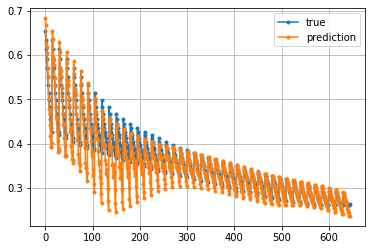

TEST FR-A
MSE =  0.0025360846677056764
MAE =  0.03998629628120678


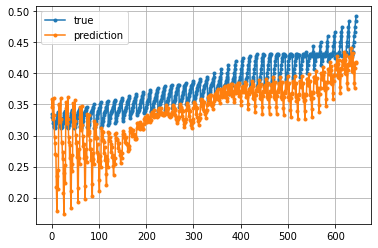

TEST FR-B
MSE =  0.006389340946089239
MAE =  0.06495097661616538


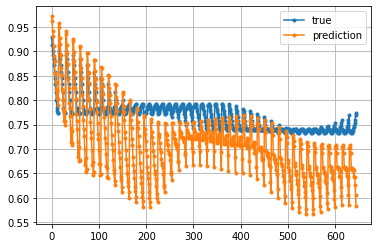

TEST FR-C
MSE =  0.008849899837096543
MAE =  0.08037282120731847


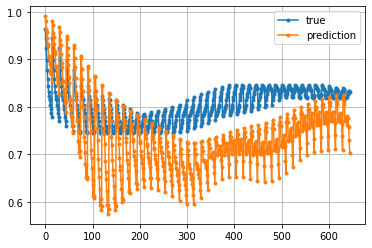

TEST FR-J
MSE =  0.0007871656240953072
MAE =  0.02355984202490225


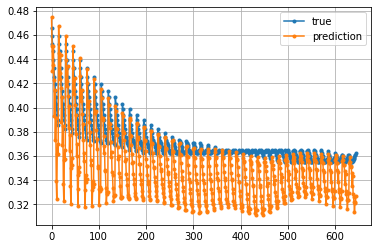

In [28]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true', marker=".")
    plt.plot(yp.reshape(-1), label='prediction', marker=".")
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
def error_set(models, points, plot=False, mode='train'):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

### Let's use the validation set

In [28]:
import keras.backend as K

weights_loss = np.array([1/x for x in range(1, n_forecast+1)])
def custom_loss_function(y_true, y_pred):
    y_true = y_true * weights_loss
    y_pred = y_pred * weights_loss
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def run_model(x_train, y_train, x_val, y_val, p):
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=True, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(LSTM(32, input_shape=(n_samples, n_features), 
                   return_sequences=False, kernel_regularizer=p['reg'](p['regw']),
                  dropout=p['dropout'], recurrent_dropout=p['recurrent_dropout']))
    model.add(Dense(n_forecast, kernel_regularizer=p['reg'](p['regw']), 
                        activation=p['activation']))
    LSTMModel = model
    
    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=p["epochs"], 
                        verbose=0, shuffle=False, 
                        validation_data=validation_generator(), validation_steps=len(valid_datapoints))
    
    return history, model
    
    
p = {'activation':['relu', 'elu'],
     'reg': [lambda x: regularizers.l1(l=x), lambda x: None],
     'regw': [5e-4, 1e-3],
     'optimizer': ['Adam', 'RMSprop'],
     'losses': ['mse', 'mae', custom_loss_function],
     'epochs': [5000, 7500, 10000],
     'dropout': [0, 0.1, 0.2],
     'recurrent_dropout': [0, 0.1, 0.2]
}

scan_object = talos.Scan(
    x=[],
    y=[],
    x_val=[],
    y_val=[],
    params=p,
    model=run_model,
    experiment_name='trends1', 
    fraction_limit=0.01
)

100%|██████████| 12/12 [4:27:55<00:00, 1339.59s/it] 


In [40]:
analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("RMSE", analyze_object.low('root_mean_squared_error'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
print("VAL RMSE", analyze_object.low('val_root_mean_squared_error'))
analyze_object.table('val_root_mean_squared_error', exclude=[], ascending=True)

MAE 0.003740368178114295
MSE 2.4614679205114953e-05
RMSE 0.004961318336427212
VAL MAE 0.11304780095815659
VAL MSE 0.03028051182627678
VAL RMSE 0.17401297390460968


,start,duration,root_mean_squared_error,mse,recurrent_dropout,end,val_loss,losses,epochs,regw,reg,optimizer,round_epochs,mae,val_mae,loss,activation,val_root_mean_squared_error,dropout,val_mse
4,01/28/21-230035,1004.834533,0.015953,0.000255,0.1,01/28/21-231720,0.000588,<function custom_loss_function at 0x7fe2c3991280>,5000,0.0010,<function <lambda> at 0x7fe2c3991a60>,RMSprop,5000,0.011198,0.113048,0.000019,elu,0.174013,0.0,0.030281
9,01/29/21-005045,1016.886581,0.007866,0.000062,0.1,01/29/21-010742,0.039364,mse,5000,0.0010,<function <lambda> at 0x7fe2c3991a60>,RMSprop,5000,0.005867,0.139055,0.000062,elu,0.198404,0.0,0.039364
2,01/28/21-220149,1245.322389,0.004961,0.000025,0.0,01/28/21-222234,0.173930,mae,10000,0.0005,<function <lambda> at 0x7fe2c3991a60>,Adam,10000,0.003740,0.173930,0.003740,relu,0.241588,0.1,0.058365
6,01/28/21-235505,1158.216673,0.032828,0.001078,0.0,01/29/21-001423,0.073526,mse,10000,0.0010,<function <lambda> at 0x7fe2bafb6280>,Adam,10000,0.023369,0.189155,0.008149,elu,0.257804,0.1,0.066463
1,01/28/21-214223,1157.581054,0.053135,0.002823,0.2,01/28/21-220141,0.074527,mse,5000,0.0010,<function <lambda> at 0x7fe2bafb6280>,Adam,5000,0.038121,0.194416,0.009940,relu,0.259677,0.1,0.067432
5,01/28/21-231733,2243.460916,0.009429,0.000089,0.1,01/28/21-235457,0.205132,mae,10000,0.0005,<function <lambda> at 0x7fe2c3991a60>,RMSprop,10000,0.006964,0.205132,0.006964,elu,0.274630,0.1,0.075421
11,01/29/21-013612,869.337221,0.026533,0.000704,0.0,01/29/21-015042,0.198480,mae,7500,0.0005,<function <lambda> at 0x7fe2c3991a60>,RMSprop,7500,0.009621,0.198480,0.009621,relu,0.275540,0.1,0.075922
8,01/29/21-003336,1021.632074,0.035100,0.001232,0.1,01/29/21-005037,0.089643,mse,5000,0.0010,<function <lambda> at 0x7fe2bafb6280>,RMSprop,5000,0.026520,0.204941,0.010370,relu,0.283656,0.0,0.080461
0,01/28/21-212257,1164.660379,0.022384,0.000501,0.1,01/28/21-214222,0.214535,mae,5000,0.0005,<function <lambda> at 0x7fe2bafb6280>,Adam,5000,0.017444,0.205141,0.026993,relu,0.284363,0.1,0.080862
7,01/29/21-001438,1123.543496,0.205168,0.042094,0.1,01/29/21-003322,0.007927,<function custom_loss_function at 0x7fe2c3991280>,5000,0.0010,<function <lambda> at 0x7fe2bafb6280>,Adam,5000,0.147901,0.262463,0.002887,relu,0.348263,0.2,0.121287


BE
FR-A
FR-B
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
LSTM tuned,3545.133099,34.390352,4602.919484,42.984721,7616.12629,57.612492,9946.275014,69.666641,14101.232517,85.641636,...,85939.221147,231.623023,98679.507387,247.492134,125362.568338,279.821806,138846.343843,295.576987,146353.818156,305.024942


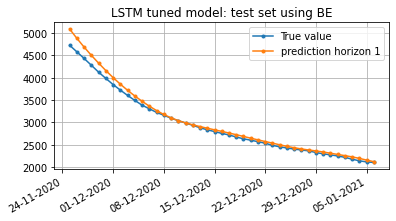

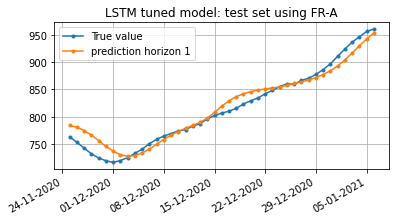

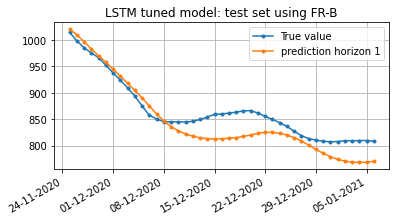

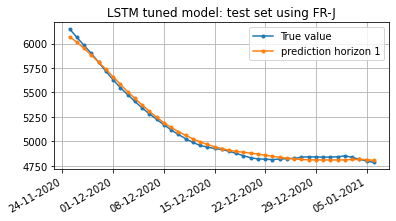

In [46]:
best_model = scan_object.best_model('val_root_mean_squared_error', asc=True)
error_set({'LSTM tuned': best_model}, test_datapoints, plot=True, mode='test')

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [31]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # target of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat target n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [32]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, target_idx]  # target of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the target
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, target)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [33]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,target_idx]))  # select only the target of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next target based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [34]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/2800
4/4 [==============================] - 0s 26ms/step - loss: 0.2628 - mean_absolute_error: 0.2964 - val_loss: 0.3949 - val_mean_absolute_error: 0.4501
Epoch 2/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.2155 - mean_absolute_error: 0.2613 - val_loss: 0.3573 - val_mean_absolute_error: 0.4288
Epoch 3/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.1867 - mean_absolute_error: 0.2394 - val_loss: 0.3277 - val_mean_absolute_error: 0.4111
Epoch 4/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.1639 - mean_absolute_error: 0.2212 - val_loss: 0.3025 - val_mean_absolute_error: 0.3950
Epoch 5/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.1446 - mean_absolute_error: 0.2049 - val_loss: 0.2800 - val_mean_absolute_error: 0.3802
Epoch 6/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.1277 - mean_absolute_error: 0.1902 - val_loss: 0.2597 - val_mean_absolute_error: 0.3661
Epoch 7/2800
4/4 [====

4/4 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0364 - val_loss: 0.0605 - val_mean_absolute_error: 0.1787
Epoch 52/2800
4/4 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_absolute_error: 0.0359 - val_loss: 0.0601 - val_mean_absolute_error: 0.1780
Epoch 53/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_absolute_error: 0.0353 - val_loss: 0.0596 - val_mean_absolute_error: 0.1773
Epoch 54/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_absolute_error: 0.0348 - val_loss: 0.0592 - val_mean_absolute_error: 0.1766
Epoch 55/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0343 - val_loss: 0.0587 - val_mean_absolute_error: 0.1760
Epoch 56/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0339 - val_loss: 0.0583 - val_mean_absolute_error: 0.1753
Epoch 57/2800
4/4 [============

4/4 [==============================] - 0s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0279 - val_loss: 0.0498 - val_mean_absolute_error: 0.1605
Epoch 102/2800
4/4 [==============================] - 0s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0279 - val_loss: 0.0497 - val_mean_absolute_error: 0.1603
Epoch 103/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_absolute_error: 0.0279 - val_loss: 0.0497 - val_mean_absolute_error: 0.1602
Epoch 104/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0278 - val_loss: 0.0496 - val_mean_absolute_error: 0.1601
Epoch 105/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_absolute_error: 0.0278 - val_loss: 0.0495 - val_mean_absolute_error: 0.1599
Epoch 106/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0278 - val_loss: 0.0495 - val_mean_absolute_error: 0.1598
Epoch 107/2800
4/4 [=======

Epoch 151/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0472 - val_mean_absolute_error: 0.1557
Epoch 152/2800
4/4 [==============================] - 0s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0471 - val_mean_absolute_error: 0.1556
Epoch 153/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0471 - val_mean_absolute_error: 0.1556
Epoch 154/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0471 - val_mean_absolute_error: 0.1555
Epoch 155/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0470 - val_mean_absolute_error: 0.1554
Epoch 156/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0470 - val_mean_absolute_error: 0.1554
Epoch 157/28

Epoch 201/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0454 - val_mean_absolute_error: 0.1524
Epoch 202/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0454 - val_mean_absolute_error: 0.1524
Epoch 203/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0453 - val_mean_absolute_error: 0.1523
Epoch 204/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0453 - val_mean_absolute_error: 0.1523
Epoch 205/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0453 - val_mean_absolute_error: 0.1522
Epoch 206/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - val_loss: 0.0452 - val_mean_absolute_error: 0.1521
Epoch 207/

Epoch 251/2800
4/4 [==============================] - 0s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0438 - val_mean_absolute_error: 0.1494
Epoch 252/2800
4/4 [==============================] - 0s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0438 - val_mean_absolute_error: 0.1494
Epoch 253/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0437 - val_mean_absolute_error: 0.1493
Epoch 254/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0437 - val_mean_absolute_error: 0.1493
Epoch 255/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0437 - val_mean_absolute_error: 0.1492
Epoch 256/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0436 - val_mean_absolute_error: 0.1491
Epoch 257/

Epoch 301/2800
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0423 - val_mean_absolute_error: 0.1465
Epoch 302/2800
4/4 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0422 - val_mean_absolute_error: 0.1465
Epoch 303/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0422 - val_mean_absolute_error: 0.1464
Epoch 304/2800
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0422 - val_mean_absolute_error: 0.1463
Epoch 305/2800
4/4 [==============================] - 0s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0422 - val_mean_absolute_error: 0.1463
Epoch 306/2800
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0258 - val_loss: 0.0421 - val_mean_absolute_error: 0.1462
Epoch 307/

Epoch 351/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0408 - val_mean_absolute_error: 0.1437
Epoch 352/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0408 - val_mean_absolute_error: 0.1436
Epoch 353/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0408 - val_mean_absolute_error: 0.1436
Epoch 354/2800
4/4 [==============================] - 0s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0407 - val_mean_absolute_error: 0.1435
Epoch 355/2800
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0407 - val_mean_absolute_error: 0.1435
Epoch 356/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0253 - val_loss: 0.0407 - val_mean_absolute_error: 0.1434
Epoch 357/28

Epoch 401/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0394 - val_mean_absolute_error: 0.1410
Epoch 402/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0394 - val_mean_absolute_error: 0.1409
Epoch 403/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0394 - val_mean_absolute_error: 0.1408
Epoch 404/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0394 - val_mean_absolute_error: 0.1408
Epoch 405/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0393 - val_mean_absolute_error: 0.1407
Epoch 406/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0248 - val_loss: 0.0393 - val_mean_absolute_error: 0.1407
Epoch 407/2800
4

Epoch 451/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0244 - val_loss: 0.0381 - val_mean_absolute_error: 0.1383
Epoch 452/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0244 - val_loss: 0.0381 - val_mean_absolute_error: 0.1383
Epoch 453/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0244 - val_loss: 0.0381 - val_mean_absolute_error: 0.1382
Epoch 454/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0244 - val_loss: 0.0380 - val_mean_absolute_error: 0.1382
Epoch 455/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0244 - val_loss: 0.0380 - val_mean_absolute_error: 0.1381
Epoch 456/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0244 - val_loss: 0.0380 - val_mean_absolute_error: 0.1380
Epoch 457/2800
4

Epoch 501/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 0.0369 - val_mean_absolute_error: 0.1357
Epoch 502/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 0.0369 - val_mean_absolute_error: 0.1357
Epoch 503/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0239 - val_loss: 0.0368 - val_mean_absolute_error: 0.1356
Epoch 504/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0239 - val_loss: 0.0368 - val_mean_absolute_error: 0.1356
Epoch 505/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0239 - val_loss: 0.0368 - val_mean_absolute_error: 0.1355
Epoch 506/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0239 - val_loss: 0.0368 - val_mean_absolute_error: 0.1355
Epoch 507/2800
4

Epoch 551/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0357 - val_mean_absolute_error: 0.1333
Epoch 552/2800
4/4 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0357 - val_mean_absolute_error: 0.1332
Epoch 553/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0356 - val_mean_absolute_error: 0.1332
Epoch 554/2800
4/4 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0356 - val_mean_absolute_error: 0.1331
Epoch 555/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0356 - val_mean_absolute_error: 0.1331
Epoch 556/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0356 - val_mean_absolute_error: 0.1330
Epoch 557/2

Epoch 601/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0346 - val_mean_absolute_error: 0.1309
Epoch 602/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0345 - val_mean_absolute_error: 0.1308
Epoch 603/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0345 - val_mean_absolute_error: 0.1308
Epoch 604/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0345 - val_mean_absolute_error: 0.1307
Epoch 605/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0345 - val_mean_absolute_error: 0.1307
Epoch 606/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0231 - val_loss: 0.0345 - val_mean_absolute_error: 0.1306
Epoch 607/2800


Epoch 651/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0228 - val_loss: 0.0335 - val_mean_absolute_error: 0.1286
Epoch 652/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 0.0335 - val_mean_absolute_error: 0.1285
Epoch 653/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 0.0335 - val_mean_absolute_error: 0.1285
Epoch 654/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 0.0334 - val_mean_absolute_error: 0.1284
Epoch 655/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 0.0334 - val_mean_absolute_error: 0.1284
Epoch 656/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 0.0334 - val_mean_absolute_error: 0.1283
Epoch 657/2800
4

Epoch 701/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0224 - val_loss: 0.0325 - val_mean_absolute_error: 0.1263
Epoch 702/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0224 - val_loss: 0.0325 - val_mean_absolute_error: 0.1263
Epoch 703/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0224 - val_loss: 0.0325 - val_mean_absolute_error: 0.1263
Epoch 704/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0223 - val_loss: 0.0324 - val_mean_absolute_error: 0.1262
Epoch 705/2800
4/4 [==============================] - 0s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0223 - val_loss: 0.0324 - val_mean_absolute_error: 0.1262
Epoch 706/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0223 - val_loss: 0.0324 - val_mean_absolute_error: 0.1261
Epoch 707/2800


Epoch 751/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0315 - val_mean_absolute_error: 0.1242
Epoch 752/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0315 - val_mean_absolute_error: 0.1242
Epoch 753/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0315 - val_mean_absolute_error: 0.1241
Epoch 754/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0315 - val_mean_absolute_error: 0.1241
Epoch 755/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0315 - val_mean_absolute_error: 0.1240
Epoch 756/2800
4/4 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0220 - val_loss: 0.0314 - val_mean_absolute_error: 0.1240
Epoch 757/2800
4

4/4 [==============================] - 0s 9ms/step - loss: 9.7978e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0307 - val_mean_absolute_error: 0.1222
Epoch 801/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.7915e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0306 - val_mean_absolute_error: 0.1222
Epoch 802/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.7853e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0306 - val_mean_absolute_error: 0.1221
Epoch 803/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.7791e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0306 - val_mean_absolute_error: 0.1221
Epoch 804/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.7728e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0306 - val_mean_absolute_error: 0.1220
Epoch 805/2800
4/4 [==============================] - 0s 10ms/step - loss: 9.7666e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0306 - val_mean_absolute_error: 0.1220
Epoch 

Epoch 849/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.5009e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0298 - val_mean_absolute_error: 0.1203
Epoch 850/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.4950e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0298 - val_mean_absolute_error: 0.1202
Epoch 851/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.4892e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0298 - val_mean_absolute_error: 0.1202
Epoch 852/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.4833e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0298 - val_mean_absolute_error: 0.1201
Epoch 853/2800
4/4 [==============================] - 0s 10ms/step - loss: 9.4775e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0298 - val_mean_absolute_error: 0.1201
Epoch 854/2800
4/4 [==============================] - 0s 9ms/step - loss: 9.4716e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0297 - val_mean_absolute_error

4/4 [==============================] - 0s 11ms/step - loss: 9.2278e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1184
Epoch 898/2800
4/4 [==============================] - 0s 14ms/step - loss: 9.2222e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1184
Epoch 899/2800
4/4 [==============================] - 0s 10ms/step - loss: 9.2167e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1184
Epoch 900/2800
4/4 [==============================] - 0s 10ms/step - loss: 9.2112e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1183
Epoch 901/2800
4/4 [==============================] - 0s 12ms/step - loss: 9.2058e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1183
Epoch 902/2800
4/4 [==============================] - 0s 12ms/step - loss: 9.2003e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0290 - val_mean_absolute_error: 0.1183
E

4/4 [==============================] - 0s 9ms/step - loss: 8.9712e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0283 - val_mean_absolute_error: 0.1167
Epoch 946/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.9660e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0283 - val_mean_absolute_error: 0.1167
Epoch 947/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.9609e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0283 - val_mean_absolute_error: 0.1166
Epoch 948/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.9557e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0283 - val_mean_absolute_error: 0.1166
Epoch 949/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.9506e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0283 - val_mean_absolute_error: 0.1165
Epoch 950/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.9454e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0282 - val_mean_absolute_error: 0.1165
Epoch 

Epoch 994/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.7255e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0276 - val_mean_absolute_error: 0.1150
Epoch 995/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.7207e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0276 - val_mean_absolute_error: 0.1149
Epoch 996/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.7158e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0276 - val_mean_absolute_error: 0.1149
Epoch 997/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.7110e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0276 - val_mean_absolute_error: 0.1149
Epoch 998/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.7062e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0275 - val_mean_absolute_error: 0.1148
Epoch 999/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.7013e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0275 - val_mean_absolute_error

4/4 [==============================] - 0s 9ms/step - loss: 8.4998e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0270 - val_mean_absolute_error: 0.1134
Epoch 1043/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.4952e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0269 - val_mean_absolute_error: 0.1133
Epoch 1044/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.4907e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0269 - val_mean_absolute_error: 0.1133
Epoch 1045/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.4862e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0269 - val_mean_absolute_error: 0.1133
Epoch 1046/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.4816e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0269 - val_mean_absolute_error: 0.1132
Epoch 1047/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.4771e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0269 - val_mean_absolute_error: 0.1132


4/4 [==============================] - 0s 10ms/step - loss: 8.2880e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1118
Epoch 1091/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.2838e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1118
Epoch 1092/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.2795e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1118
Epoch 1093/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.2752e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1117
Epoch 1094/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.2710e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1117
Epoch 1095/2800
4/4 [==============================] - 0s 9ms/step - loss: 8.2667e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0263 - val_mean_absolute_error: 0.1117


4/4 [==============================] - 0s 10ms/step - loss: 8.0894e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0258 - val_mean_absolute_error: 0.1104
Epoch 1139/2800
4/4 [==============================] - 0s 11ms/step - loss: 8.0854e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0257 - val_mean_absolute_error: 0.1103
Epoch 1140/2800
4/4 [==============================] - 0s 11ms/step - loss: 8.0814e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0257 - val_mean_absolute_error: 0.1103
Epoch 1141/2800
4/4 [==============================] - 0s 10ms/step - loss: 8.0774e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0257 - val_mean_absolute_error: 0.1103
Epoch 1142/2800
4/4 [==============================] - 0s 11ms/step - loss: 8.0735e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0257 - val_mean_absolute_error: 0.1102
Epoch 1143/2800
4/4 [==============================] - 0s 11ms/step - loss: 8.0695e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0257 - val_mean_absolute_error: 0.1

4/4 [==============================] - 0s 9ms/step - loss: 7.9032e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.1089
Epoch 1187/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.8995e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.1089
Epoch 1188/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.8957e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.1089
Epoch 1189/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.8920e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.1089
Epoch 1190/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.8882e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.1088
Epoch 1191/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.8845e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0252 - val_mean_absolute_error: 0.10

4/4 [==============================] - 0s 10ms/step - loss: 7.7286e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0247 - val_mean_absolute_error: 0.1076
Epoch 1235/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.7251e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0247 - val_mean_absolute_error: 0.1076
Epoch 1236/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.7216e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0247 - val_mean_absolute_error: 0.1075
Epoch 1237/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.7181e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0247 - val_mean_absolute_error: 0.1075
Epoch 1238/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.7146e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0246 - val_mean_absolute_error: 0.1075
Epoch 1239/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.7111e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0246 - val_mean_absolute_error: 0.1

4/4 [==============================] - 0s 10ms/step - loss: 7.5649e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1063
Epoch 1283/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.5616e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1063
Epoch 1284/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.5583e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1063
Epoch 1285/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.5551e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1062
Epoch 1286/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.5518e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1062
Epoch 1287/2800
4/4 [==============================] - 0s 12ms/step - loss: 7.5485e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0242 - val_mean_absolute_error: 0.1

4/4 [==============================] - 0s 10ms/step - loss: 7.4114e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1051
Epoch 1331/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.4083e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1051
Epoch 1332/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.4052e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1050
Epoch 1333/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.4021e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1050
Epoch 1334/2800
4/4 [==============================] - 0s 12ms/step - loss: 7.3990e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1050
Epoch 1335/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.3960e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0237 - val_mean_absolute_error: 0.1

4/4 [==============================] - 0s 12ms/step - loss: 7.2673e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1039
Epoch 1379/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.2644e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1039
Epoch 1380/2800
4/4 [==============================] - 0s 12ms/step - loss: 7.2615e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1039
Epoch 1381/2800
4/4 [==============================] - 0s 12ms/step - loss: 7.2586e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1039
Epoch 1382/2800
4/4 [==============================] - 0s 13ms/step - loss: 7.2557e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1038
Epoch 1383/2800
4/4 [==============================] - 0s 19ms/step - loss: 7.2528e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0233 - val_mean_absolute_error: 0.1

4/4 [==============================] - 0s 10ms/step - loss: 7.1319e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.1028
Epoch 1427/2800
4/4 [==============================] - 0s 11ms/step - loss: 7.1292e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.1028
Epoch 1428/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.1264e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.1028
Epoch 1429/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.1237e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.1028
Epoch 1430/2800
4/4 [==============================] - 0s 9ms/step - loss: 7.1210e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.1027
Epoch 1431/2800
4/4 [==============================] - 0s 10ms/step - loss: 7.1183e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0229 - val_mean_absolute_error: 0.10

4/4 [==============================] - 0s 10ms/step - loss: 7.0045e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1018
Epoch 1475/2800
4/4 [==============================] - 0s 9ms/step - loss: 7.0020e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1018
Epoch 1476/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.9994e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1018
Epoch 1477/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.9968e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1017
Epoch 1478/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.9943e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1017
Epoch 1479/2800
4/4 [==============================] - 0s 11ms/step - loss: 6.9917e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0225 - val_mean_absolute_error: 0.1017


4/4 [==============================] - 0s 11ms/step - loss: 6.8845e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0222 - val_mean_absolute_error: 0.1008
Epoch 1523/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.8821e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0222 - val_mean_absolute_error: 0.1008
Epoch 1524/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.8797e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0222 - val_mean_absolute_error: 0.1008
Epoch 1525/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.8773e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0221 - val_mean_absolute_error: 0.1007
Epoch 1526/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.8749e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0221 - val_mean_absolute_error: 0.1007
Epoch 1527/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.8724e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0221 - val_mean_absolute_error: 0.100

4/4 [==============================] - 0s 10ms/step - loss: 6.7713e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.0999
Epoch 1571/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.7690e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.0998
Epoch 1572/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.7667e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.0998
Epoch 1573/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.7644e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.0998
Epoch 1574/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.7621e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.0998
Epoch 1575/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.7598e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0218 - val_mean_absolute_error: 0.09

4/4 [==============================] - 0s 9ms/step - loss: 6.6642e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989
Epoch 1619/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.6620e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989
Epoch 1620/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.6598e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989
Epoch 1621/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.6577e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989
Epoch 1622/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.6555e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989
Epoch 1623/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.6533e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0215 - val_mean_absolute_error: 0.0989


4/4 [==============================] - 0s 10ms/step - loss: 6.5626e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0981
Epoch 1667/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.5606e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0981
Epoch 1668/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.5585e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0980
Epoch 1669/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.5564e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0980
Epoch 1670/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.5544e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0980
Epoch 1671/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.5523e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0212 - val_mean_absolute_error: 0.0980

4/4 [==============================] - 0s 9ms/step - loss: 6.4662e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.0973
Epoch 1715/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.4642e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.0972
Epoch 1716/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.4623e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.0972
Epoch 1717/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.4603e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.0972
Epoch 1718/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.4584e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.0972
Epoch 1719/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.4564e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0209 - val_mean_absolute_error: 0.09

4/4 [==============================] - 0s 10ms/step - loss: 6.3744e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0965
Epoch 1763/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.3725e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0965
Epoch 1764/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.3706e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0964
Epoch 1765/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.3688e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0964
Epoch 1766/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.3669e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0964
Epoch 1767/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.3651e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0206 - val_mean_absolute_error: 0.0

4/4 [==============================] - 0s 10ms/step - loss: 6.2868e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.0957
Epoch 1811/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.2850e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.0957
Epoch 1812/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.2832e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.0957
Epoch 1813/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.2814e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.0957
Epoch 1814/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.2797e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.0957
Epoch 1815/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.2779e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0204 - val_mean_absolute_error: 0.09

4/4 [==============================] - 0s 10ms/step - loss: 6.2031e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.0950
Epoch 1859/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.2014e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.0950
Epoch 1860/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.1997e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.0950
Epoch 1861/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.1980e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.0950
Epoch 1862/2800
4/4 [==============================] - 0s 11ms/step - loss: 6.1963e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.0950
Epoch 1863/2800
4/4 [==============================] - 0s 11ms/step - loss: 6.1946e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0201 - val_mean_absolute_error: 0.095

4/4 [==============================] - 0s 9ms/step - loss: 6.1229e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0944
Epoch 1907/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.1212e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943
Epoch 1908/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.1196e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943
Epoch 1909/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.1180e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943
Epoch 1910/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.1163e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943
Epoch 1911/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.1147e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943
E

4/4 [==============================] - 0s 10ms/step - loss: 6.0459e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0197 - val_mean_absolute_error: 0.0937
Epoch 1955/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.0443e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0197 - val_mean_absolute_error: 0.0937
Epoch 1956/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.0428e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0197 - val_mean_absolute_error: 0.0937
Epoch 1957/2800
4/4 [==============================] - 0s 10ms/step - loss: 6.0412e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0197 - val_mean_absolute_error: 0.0937
Epoch 1958/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.0396e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0197 - val_mean_absolute_error: 0.0936
Epoch 1959/2800
4/4 [==============================] - 0s 9ms/step - loss: 6.0381e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0196 - val_mean_absolute_error: 0.093

4/4 [==============================] - 0s 10ms/step - loss: 5.9719e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0195 - val_mean_absolute_error: 0.0931
Epoch 2003/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.9704e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0195 - val_mean_absolute_error: 0.0931
Epoch 2004/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.9689e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0194 - val_mean_absolute_error: 0.0930
Epoch 2005/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.9674e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0194 - val_mean_absolute_error: 0.0930
Epoch 2006/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.9659e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0194 - val_mean_absolute_error: 0.0930
Epoch 2007/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.9644e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0194 - val_mean_absolute_error: 0.0930

4/4 [==============================] - 0s 9ms/step - loss: 5.9007e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0925
Epoch 2051/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.8992e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0925
Epoch 2052/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8978e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0925
Epoch 2053/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.8963e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0924
Epoch 2054/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.8949e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0924
Epoch 2055/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8934e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0192 - val_mean_absolute_error: 0.0924

4/4 [==============================] - 0s 9ms/step - loss: 5.8320e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0191 - val_mean_absolute_error: 0.0919
Epoch 2099/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8306e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0190 - val_mean_absolute_error: 0.0919
Epoch 2100/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8292e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0190 - val_mean_absolute_error: 0.0919
Epoch 2101/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8278e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0190 - val_mean_absolute_error: 0.0919
Epoch 2102/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8264e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0190 - val_mean_absolute_error: 0.0919
Epoch 2103/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.8250e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0190 - val_mean_absolute_error: 0.0918
Ep

4/4 [==============================] - 0s 9ms/step - loss: 5.7656e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0913
Epoch 2147/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.7643e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0913
Epoch 2148/2800
4/4 [==============================] - 0s 8ms/step - loss: 5.7629e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0913
Epoch 2149/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.7616e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0913
Epoch 2150/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.7602e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0188 - val_mean_absolute_error: 0.0913
Epoch 2151/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.7589e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0188 - val_mean_absolute_error: 0.0913
E

4/4 [==============================] - 0s 9ms/step - loss: 5.7015e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 2195/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.7002e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 2196/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.6988e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 2197/2800
4/4 [==============================] - 0s 8ms/step - loss: 5.6975e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 2198/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.6962e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 2199/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.6949e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Ep

4/4 [==============================] - 0s 12ms/step - loss: 5.6393e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0903
Epoch 2243/2800
4/4 [==============================] - 0s 12ms/step - loss: 5.6381e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0903
Epoch 2244/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.6368e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0903
Epoch 2245/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.6355e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0903
Epoch 2246/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.6342e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0903
Epoch 2247/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.6330e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0185 - val_mean_absolute_error: 0.0

4/4 [==============================] - 0s 9ms/step - loss: 5.5791e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0898
Epoch 2291/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.5779e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0898
Epoch 2292/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.5766e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0898
Epoch 2293/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.5754e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0898
Epoch 2294/2800
4/4 [==============================] - 0s 14ms/step - loss: 5.5742e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0898
Epoch 2295/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.5729e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0897
E

4/4 [==============================] - 0s 11ms/step - loss: 5.5207e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 2339/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.5195e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 2340/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.5183e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 2341/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.5171e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 2342/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.5159e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 2343/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.5147e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0182 - val_mean_absolute_error: 0.0

4/4 [==============================] - 0s 10ms/step - loss: 5.4639e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.0889
Epoch 2387/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4627e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.0888
Epoch 2388/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4616e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.0888
Epoch 2389/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4604e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.0888
Epoch 2390/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4592e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.0888
Epoch 2391/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.4581e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0180 - val_mean_absolute_error: 0.08

4/4 [==============================] - 0s 12ms/step - loss: 5.4087e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0884
Epoch 2435/2800
4/4 [==============================] - 0s 13ms/step - loss: 5.4076e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0884
Epoch 2436/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4065e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0884
Epoch 2437/2800
4/4 [==============================] - 0s 12ms/step - loss: 5.4053e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0884
Epoch 2438/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4042e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0884
Epoch 2439/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.4031e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0179 - val_mean_absolute_error: 0.0

4/4 [==============================] - 0s 10ms/step - loss: 5.3551e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0177 - val_mean_absolute_error: 0.0880
Epoch 2483/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.3540e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0177 - val_mean_absolute_error: 0.0880
Epoch 2484/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.3529e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0177 - val_mean_absolute_error: 0.0880
Epoch 2485/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.3518e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0177 - val_mean_absolute_error: 0.0879
Epoch 2486/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.3507e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0177 - val_mean_absolute_error: 0.0879
Epoch 2487/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.3496e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0177 - val_mean_absolute_error: 0.0

4/4 [==============================] - 0s 9ms/step - loss: 5.3028e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.0876
Epoch 2531/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.3017e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.0875
Epoch 2532/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.3007e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.0875
Epoch 2533/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2996e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.0875
Epoch 2534/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2985e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.0875
Epoch 2535/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2975e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0176 - val_mean_absolute_error: 0.087

4/4 [==============================] - 0s 10ms/step - loss: 5.2519e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0175 - val_mean_absolute_error: 0.0871
Epoch 2579/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2509e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0175 - val_mean_absolute_error: 0.0871
Epoch 2580/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.2498e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0175 - val_mean_absolute_error: 0.0871
Epoch 2581/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2488e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0175 - val_mean_absolute_error: 0.0871
Epoch 2582/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2478e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0175 - val_mean_absolute_error: 0.0871
Epoch 2583/2800
4/4 [==============================] - 0s 12ms/step - loss: 5.2467e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0174 - val_mean_absolute_error: 0.08

4/4 [==============================] - 0s 11ms/step - loss: 5.2024e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.0867
Epoch 2627/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.2013e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.0867
Epoch 2628/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.2003e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.0867
Epoch 2629/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1993e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.0867
Epoch 2630/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.1983e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.0867
Epoch 2631/2800
4/4 [==============================] - 1s 214ms/step - loss: 5.1973e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0173 - val_mean_absolute_error: 0.

4/4 [==============================] - 0s 9ms/step - loss: 5.1540e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.0864
Epoch 2675/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1530e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.0864
Epoch 2676/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1520e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.0863
Epoch 2677/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1510e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.0863
Epoch 2678/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1500e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.0863
Epoch 2679/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1490e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0172 - val_mean_absolute_error: 0.08

4/4 [==============================] - 0s 9ms/step - loss: 5.1069e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.0860
Epoch 2723/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1059e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.0860
Epoch 2724/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1049e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.0860
Epoch 2725/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1040e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.0860
Epoch 2726/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1030e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.0860
Epoch 2727/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.1020e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0171 - val_mean_absolute_error: 0.08

4/4 [==============================] - 0s 11ms/step - loss: 5.0608e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.0856
Epoch 2771/2800
4/4 [==============================] - 0s 11ms/step - loss: 5.0599e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.0856
Epoch 2772/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.0590e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.0856
Epoch 2773/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.0580e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.0856
Epoch 2774/2800
4/4 [==============================] - 0s 9ms/step - loss: 5.0571e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.0856
Epoch 2775/2800
4/4 [==============================] - 0s 10ms/step - loss: 5.0561e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0170 - val_mean_absolute_error: 0.085

# Comparisons of the models

In [35]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM_tuned': best_model,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=False, mode='train', rescale=True):
    """
    compute the MAE and MSE on the models given, on all possible horizon
    :param models: dict of models to evaluate
    :param points: dict of {loc: [x,y]} to use to compute the error
    :param plot: whether to plot the predictions or not
    :param mode: one of ['train', 'valid', 'test']. Used to deduce the index of the datapoints, needed
        to show the dates in the plot. No effect if plot=False
    :param rescale: whether to compute the error according to the rescaled data or not
    :return df_errors: dataframe with one pair of [MSE, MAE] columns for each horizon and each entry line per model
    """
    y_predicted = {k: {loc: None for loc in points} for k in models.keys()}
    y_true = {loc: None for loc in points}
    if plot:
        if mode == 'train':
            idx = train_idx
        elif mode == 'valid':
            idx = valid_idx
        elif mode == 'test':
            idx = test_idx
    for loc in points:
        print(loc)
        x, y = points[loc]
        y_true[loc] = y
        for name, model in models.items():
            yp = model.predict(x)
            if plot:
                plot_prediction_vs_actual(yp, idx, loc, show_fit=0)
                plt.title(f'{name} model: {mode} set using {loc}')
            y_predicted[name][loc] = yp
    MSE = {}
    MAE = {}
    for i in range(n_forecast):
        MSE[f'MSE (t+{i+1})'] = []
        MAE[f'MAE (t+{i+1})'] = []
        models_names = []
        if rescale:
            y_true_horizon = np.array([mapper(l[:,i].reshape(-1), loc) for loc, l in y_true.items()]).reshape(-1)
        else:
            y_true_horizon = np.array([l[:,i] for l in y_true.values()]).reshape(-1)
        for k in models.keys():
            models_names.append(k)
            if rescale:
                y_predicted_horizon = np.array([mapper(l[:,i], loc) for loc, l in y_predicted[k].items()]).reshape(-1)
            else:
                y_predicted_horizon = np.array([l[:,i] for l in y_predicted[k].values()]).reshape(-1)
            MSE[f'MSE (t+{i+1})'].append(mean_squared_error(y_true_horizon, y_predicted_horizon))
            MAE[f'MAE (t+{i+1})'].append(mean_absolute_error(y_true_horizon, y_predicted_horizon))
        #df_errors[i+1] = pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])
    data = {'Model': models_names, **MSE, **MAE}
    df_errors = pd.DataFrame(data=data).set_index('Model').sort_values(by=['MSE (t+1)'])
    # order with respect to the time
    columns = df_errors.columns.to_list()
    columns.sort(key = lambda x: int(re.search("\(t\+(\d+)\)", x).group(1)))
    df_errors = df_errors[columns]
    return df_errors

## Training

BE
FR-A
FR-B
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
RepeatLast,2523.474608,28.773840,9980.874869,57.229201,22551.736976,85.333369,40506.015251,113.434559,63398.978347,141.309562,...,3.198249e+05,327.247061,3.782594e+05,356.934563,4.421622e+05,385.782777,5.125891e+05,413.967301,5.840248e+05,440.863134
LSTM_tuned,2680.317574,34.356660,2838.909810,35.152715,3078.131396,35.289859,2572.017953,31.796553,2546.834972,32.568471,...,4.129162e+03,40.731050,4.965210e+03,47.092486,4.884868e+03,46.823356,5.238866e+03,47.896734,7.334363e+03,54.937888
Dense,3913.251024,36.684858,4934.603490,40.353924,6819.053426,46.401466,4913.771178,40.836397,10872.972912,55.967742,...,3.555480e+04,107.747969,4.877328e+04,123.046376,5.874013e+04,133.774785,5.512259e+04,134.024897,6.624381e+04,151.047440
Linear regression,184880.154740,156.919286,275032.531865,188.825064,385946.043402,221.518146,524520.621929,256.072711,684329.333297,290.034011,...,2.135283e+06,510.568521,2.457893e+06,547.334066,2.805453e+06,584.208521,3.178290e+06,622.984762,3.563087e+06,661.478265


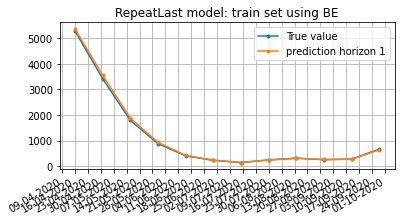

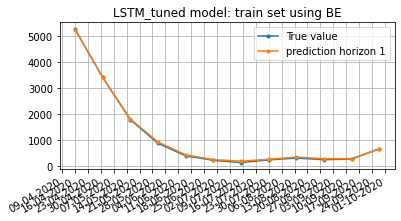

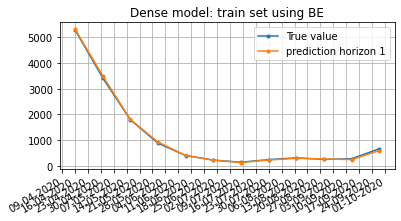

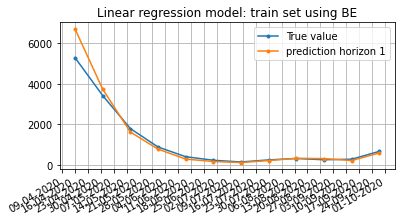

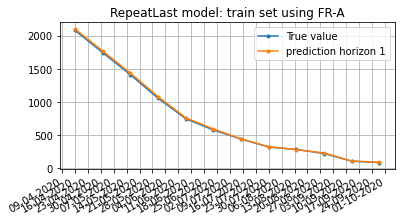

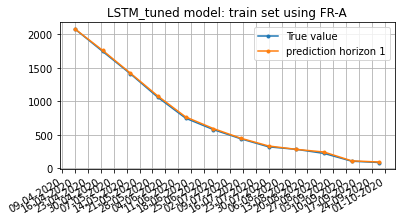

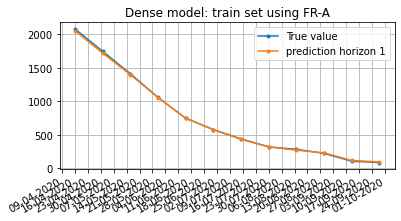

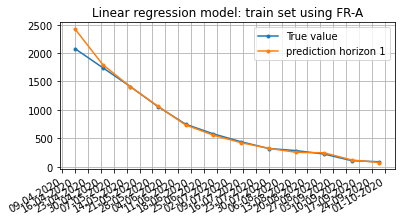

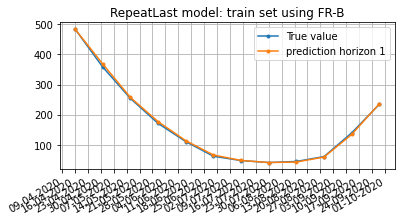

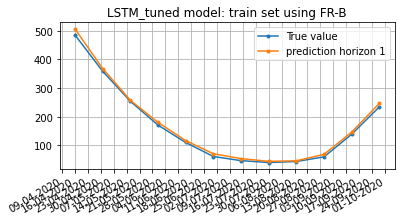

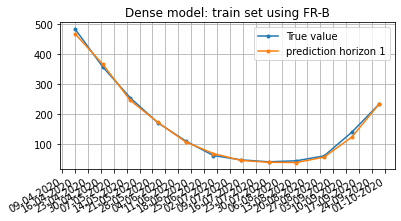

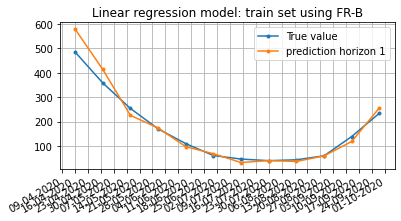

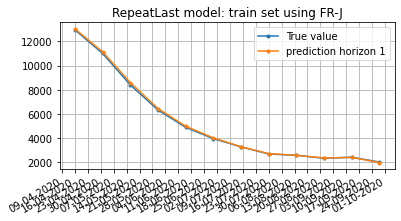

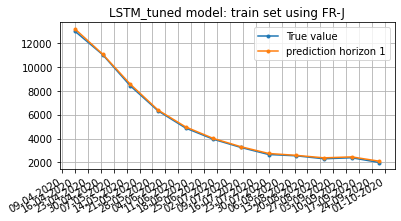

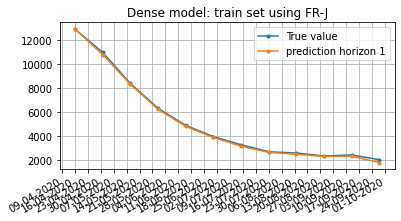

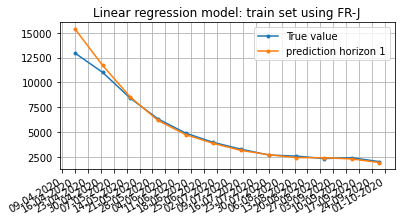

In [36]:
error_set(all_models, train_datapoints, plot=True, mode='train')

## Validation

BE
FR-A
FR-B
FR-J


,MSE (t+1),MAE (t+1),MSE (t+2),MAE (t+2),MSE (t+3),MAE (t+3),MSE (t+4),MAE (t+4),MSE (t+5),MAE (t+5),...,MSE (t+11),MAE (t+11),MSE (t+12),MAE (t+12),MSE (t+13),MAE (t+13),MSE (t+14),MAE (t+14),MSE (t+15),MAE (t+15)
Model,,,,,,,,,,,,,,,,,,,,,
RepeatLast,11955.074950,68.006871,47924.047536,136.855870,107804.395302,206.276920,191277.066303,276.072034,297825.358096,346.213011,...,1.369775e+06,766.291335,1.608384e+06,835.228683,1.859720e+06,903.110889,2.121971e+06,969.591468,2.393268e+06,1035.533824
Dense,65665.145101,162.097878,102264.697039,199.019334,154249.154267,241.497853,121091.981421,213.226343,280435.090082,320.752748,...,9.106999e+05,575.834784,1.165013e+06,657.053094,1.420459e+06,733.733270,1.428133e+06,728.410331,1.741096e+06,811.918309
LSTM_tuned,87147.963009,170.983482,147284.269253,218.158416,231202.984636,281.635886,340692.648215,341.814446,484949.759918,413.945544,...,1.784536e+06,842.220799,2.032521e+06,904.935657,2.275022e+06,965.226955,2.426014e+06,1000.718857,2.627247e+06,1044.252929
Linear regression,230498.281691,289.664919,341441.939541,355.458175,481422.421278,425.700065,653124.731090,499.206888,859012.719174,576.473480,...,2.911743e+06,1095.304905,3.398826e+06,1187.805342,3.927564e+06,1281.644178,4.497314e+06,1376.867657,5.107221e+06,1471.679211


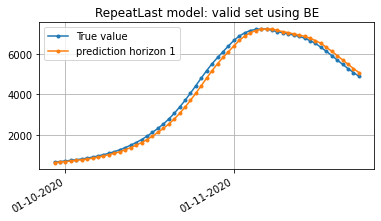

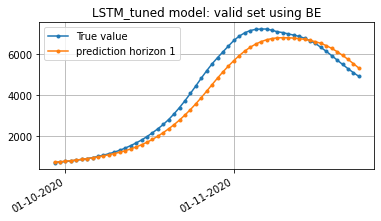

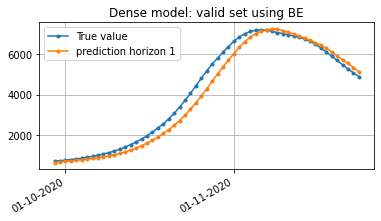

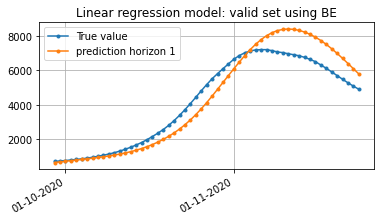

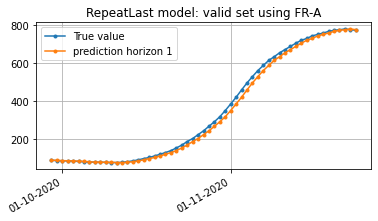

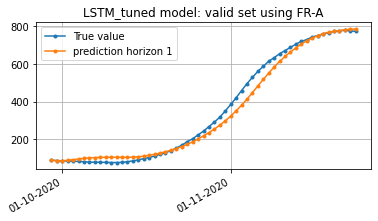

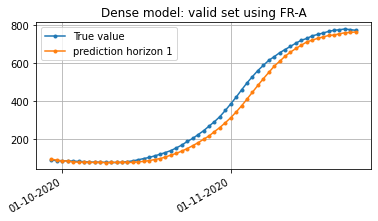

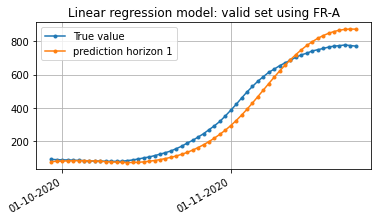

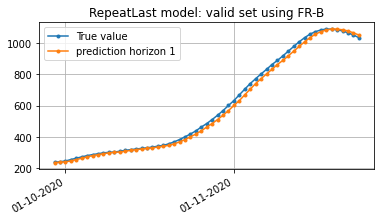

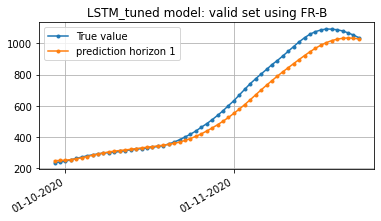

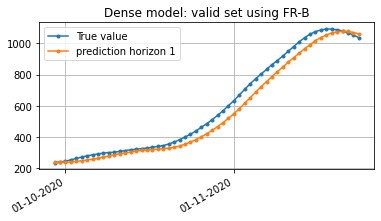

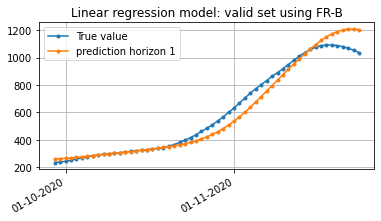

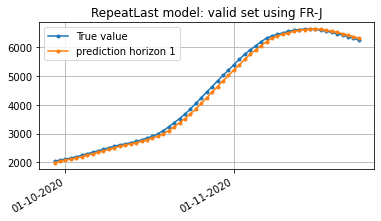

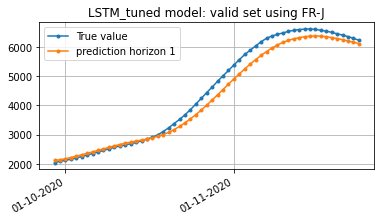

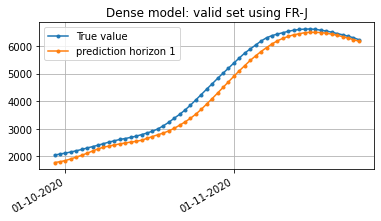

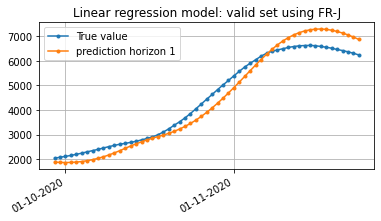

In [37]:
error_set(all_models, valid_datapoints, plot=True, mode='valid')

## Test

BE
FR-A
FR-B
FR-J


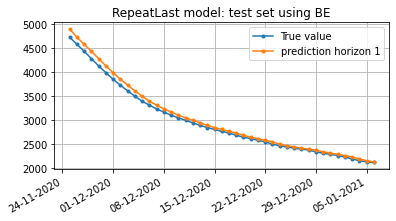

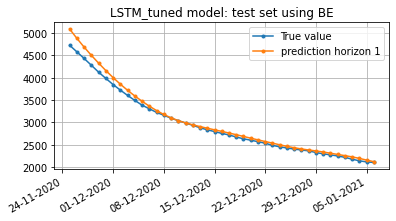

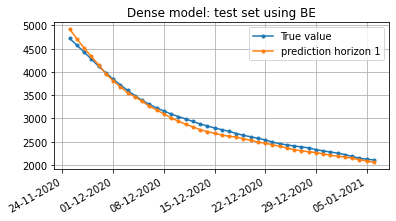

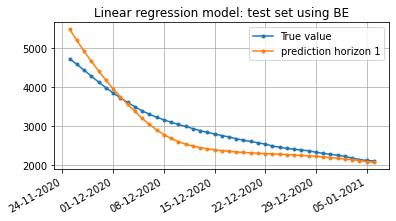

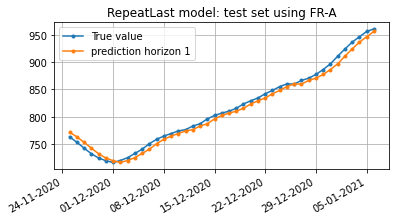

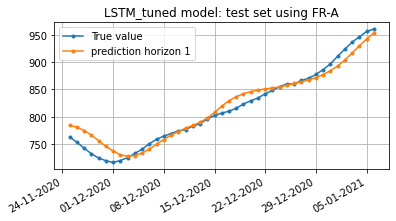

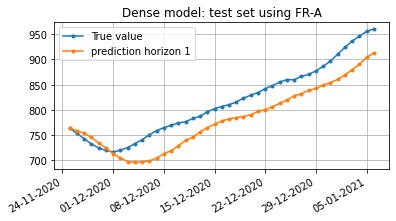

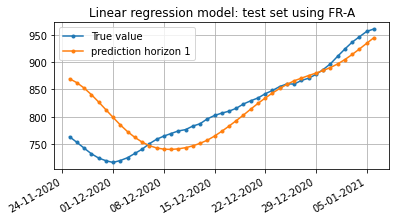

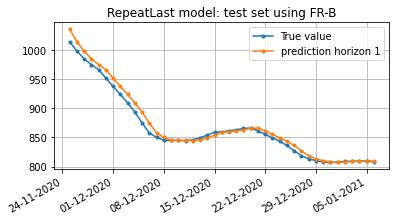

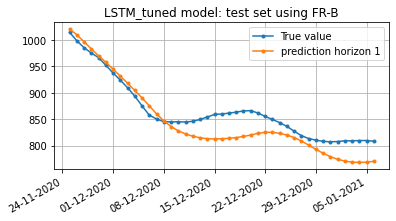

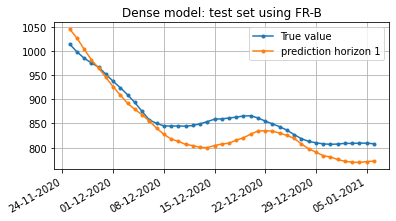

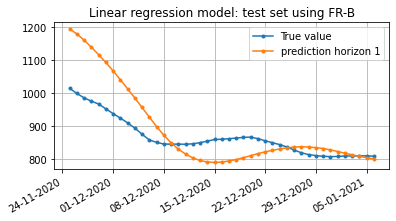

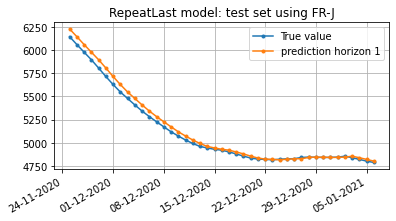

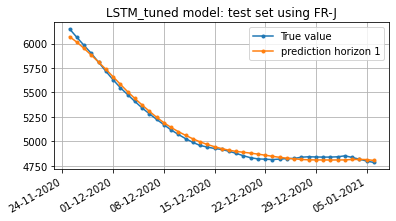

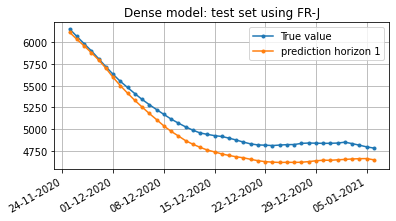

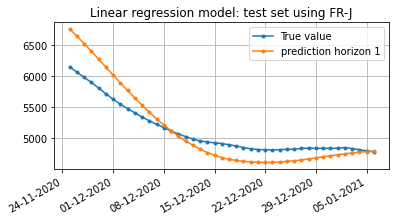

In [38]:
df = error_set(all_models, test_datapoints, plot=True, mode='test')

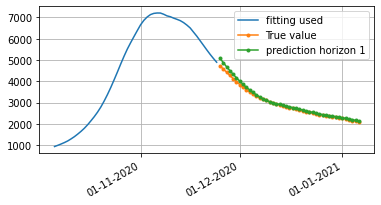

In [39]:
idx = test_idx
x = test_datapoints['BE'][0]
yp = best_model.predict(x)
plot_prediction_vs_actual(yp, idx, 'BE', show_fit=50)